In [ ]:
import pandas as pd
import glob
import os
import logging

# Paths
base_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model"
dem_path = os.path.join(base_path, "DEM-SLOPE- ETC/North_Dead_Sea_DEM.csv")
slope_path = os.path.join(base_path, "DEM-SLOPE- ETC/North_Dead_Sea_SLOPE.csv")
rain_path = os.path.join(base_path, "yearly rain")
flow_path = os.path.join(base_path, "yearly update flow")
final_output_path = os.path.join(base_path, "final dataset", "North_Dead_Sea_Final.parquet")
intermediate_path = os.path.join(base_path, "intermediate_data")
os.makedirs(intermediate_path, exist_ok=True)

# Setup logging to both file and console
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(os.path.join(base_path, "processing.log")),
        logging.StreamHandler()
    ]
)
logging.info("Starting dataset processing...")

# Load DEM & Slope Data
logging.info("Loading DEM and Slope data...")
dem_df = pd.read_csv(dem_path, dtype={'Longitude': 'float32', 'Latitude': 'float32', 'elevation': 'float32'})
slope_df = pd.read_csv(slope_path, dtype={'Longitude': 'float32', 'Latitude': 'float32', 'slope': 'float32'})
logging.info(f"Loaded DEM data with {len(dem_df)} rows and Slope data with {len(slope_df)} rows.")

# Merge DEM & Slope
dem_slope_df = dem_df.merge(slope_df, on=["Longitude", "Latitude"], suffixes=("_DEM", "_Slope"))
logging.info("Merged DEM and Slope data.")

# Load and merge yearly rain data
logging.info("Loading yearly rain data...")
rain_files = sorted(glob.glob(os.path.join(rain_path, "North_Dead_Sea_RM*.csv")))
rain_df_list = []
for file in rain_files:
    try:
        logging.info(f"Processing {file}...")
        for chunk in pd.read_csv(file, parse_dates=["time"], dtype={'longitude': 'float32', 'latitude': 'float32', 'rainrate': 'float32'}, chunksize=100000):
            logging.info(f"Loaded {len(chunk)} rows from {file}...")
            rain_df_list.append(chunk)
    except Exception as e:
        logging.error(f"Error loading {file}: {e}")
        continue
rain_df = pd.concat(rain_df_list, ignore_index=True)
rain_df[["longitude", "latitude"]] = rain_df[["longitude", "latitude"]].round(5)
logging.info("Merged all yearly rain data.")

# Load and merge yearly flow data
logging.info("Loading yearly flow data...")
flow_files = sorted(glob.glob(os.path.join(flow_path, "Northern Dead Sea_*.csv")))
flow_df_list = []
for file in flow_files:
    try:
        logging.info(f"Processing {file}...")
        temp_df = pd.read_csv(file, parse_dates=["date"], usecols=["name", "shd_id", "date", "rg_qms", "source", "lon", "lat"], dtype={'lon': 'float32', 'lat': 'float32', 'rg_qms': 'float32'})
        temp_df.rename(columns={"lon": "Longitude", "lat": "Latitude"}, inplace=True)
        temp_df[["Longitude", "Latitude"]] = temp_df[["Longitude", "Latitude"]].round(5)
        logging.info(f"Loaded {len(temp_df)} rows from {file}.")
        flow_df_list.append(temp_df)
    except Exception as e:
        logging.error(f"Error loading {file}: {e}")
        continue
flow_df = pd.concat(flow_df_list, ignore_index=True)
logging.info("Merged all yearly flow data.")

# Save intermediate datasets
rain_intermediate_path = os.path.join(intermediate_path, "rain_data.parquet")
flow_intermediate_path = os.path.join(intermediate_path, "flow_data.parquet")
dem_slope_intermediate_path = os.path.join(intermediate_path, "dem_slope_data.parquet")
rain_df.to_parquet(rain_intermediate_path)
flow_df.to_parquet(flow_intermediate_path)
dem_slope_df.to_parquet(dem_slope_intermediate_path)
logging.info("Saved intermediate datasets.")

# Merge Rain Data with DEM & Slope
logging.info("Merging rain data with DEM and Slope...")
final_df = rain_df.merge(dem_slope_df, left_on=["longitude", "latitude"], right_on=["Longitude", "Latitude"], how="left")
logging.info("Merged rain data with DEM and Slope.")

# Merge with Flow Data
logging.info("Merging with flow data...")
final_df = final_df.merge(flow_df, left_on=["time", "Longitude", "Latitude"], right_on=["date", "Longitude", "Latitude"], how="left")
final_df.drop(columns=["date"], inplace=True)
logging.info("Final merging complete.")

# Save final dataset as Parquet
final_df.to_parquet(final_output_path)
logging.info(f"Final dataset saved at {final_output_path}")

print("Final dataset processing complete.")


2025-01-29 11:21:23,320 - INFO - Starting dataset processing...
2025-01-29 11:21:23,320 - INFO - Loading DEM and Slope data...
2025-01-29 11:22:53,645 - INFO - Loaded DEM data with 167857893 rows and Slope data with 167857893 rows.
2025-01-29 11:23:33,992 - INFO - Merged DEM and Slope data.
2025-01-29 11:23:33,992 - INFO - Loading yearly rain data...
2025-01-29 11:23:33,993 - INFO - Processing /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/yearly rain/North_Dead_Sea_RM2012.csv...
2025-01-29 11:23:34,154 - INFO - Loaded 100000 rows from /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/yearly rain/North_Dead_Sea_RM2012.csv...
2025-01-29 11:23:34,311 - INFO - Loaded 100000 rows from /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/yearly rain/North_Dead_Sea_RM2012.csv...
2025-01-29 11:23:34,467 - INFO - Loaded 100000 rows from /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/yearly rain/North_Dead_Sea_RM

In [1]:
##I am building 1 DF smatrly and slowly

In [6]:
import pandas as pd

# Define file paths
dem_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM.csv"
slope_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_SLOPE.csv"
output_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM_SLOPE_MERGED.csv"

# Load the datasets
dem_df = pd.read_csv(dem_path)
slope_df = pd.read_csv(slope_path)

# Ensure column names match (adjust if necessary)
expected_columns = ['Longitude', 'Latitude', 'elevation']
if not all(col in dem_df.columns for col in expected_columns):
    raise ValueError("DEM file missing expected columns")

expected_columns = ['Longitude', 'Latitude', 'Slope']
if not all(col in slope_df.columns for col in expected_columns):
    raise ValueError("Slope file missing expected columns")

# Merge the datasets on Longitude and Latitude
merged_df = pd.merge(dem_df, slope_df, on=['Longitude', 'Latitude'], how='inner')

# Ensure no duplicates and data integrity
if len(dem_df) != len(slope_df) or len(merged_df) != len(dem_df):
    print("Warning: Mismatch in data size after merging. Check for missing coordinates.")

# Save the merged dataset
merged_df.to_csv(output_path, index=False)

print(f"Merged file saved at: {output_path}")

merged_df = pd.read_csv(output_path)


Merged file saved at: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM_SLOPE_MERGED.csv


In [4]:
dem_df.head()

,Longitude,Latitude,elevation
0,35.092362,31.435248,790.07135
1,35.092399,31.435248,789.68720
2,35.092436,31.435248,789.73083
3,35.092473,31.435248,789.43090
4,35.092510,31.435248,789.18080


In [5]:
slope_df.head()

,Longitude,Latitude,Slope
0,35.092362,31.435248,0.0
1,35.092399,31.435248,0.0
2,35.092436,31.435248,0.0
3,35.092473,31.435248,0.0
4,35.092510,31.435248,0.0


In [8]:
merged_df.head()

,Longitude,Latitude,elevation,Slope
0,35.092362,31.435248,790.07135,0.0
1,35.092399,31.435248,789.68720,0.0
2,35.092436,31.435248,789.73083,0.0
3,35.092473,31.435248,789.43090,0.0
4,35.092510,31.435248,789.18080,0.0


In [12]:
dem_df.shape

(167857893, 3)

In [13]:
slope_df.shape

(167857893, 3)

In [14]:
merged_df.shape

(158053959, 4)

In [17]:
import pandas as pd

# Define file paths
dem_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM.csv"
slope_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_SLOPE.csv"
output_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM_SLOPE_MERGED.csv"
missing_coords_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_Missing_Coordinates.csv"

# Load the datasets
dem_df = pd.read_csv(dem_path)
slope_df = pd.read_csv(slope_path)

# Ensure column names match (adjust if necessary)
expected_columns = ['Longitude', 'Latitude', 'elevation']
if not all(col in dem_df.columns for col in expected_columns):
    raise ValueError("DEM file missing expected columns")

expected_columns = ['Longitude', 'Latitude', 'Slope']
if not all(col in slope_df.columns for col in expected_columns):
    raise ValueError("Slope file missing expected columns")

# Print dataset sizes
print(f"DEM file has {len(dem_df)} rows")
print(f"Slope file has {len(slope_df)} rows")

# Identify missing coordinates
dem_coords = set(zip(dem_df['Longitude'], dem_df['Latitude']))
slope_coords = set(zip(slope_df['Longitude'], slope_df['Latitude']))

missing_in_slope = dem_coords - slope_coords
missing_in_dem = slope_coords - dem_coords

# Save missing coordinates if any
if missing_in_slope or missing_in_dem:
    missing_df = pd.DataFrame(list(missing_in_slope | missing_in_dem), columns=['Longitude', 'Latitude'])
    missing_df.to_csv(missing_coords_path, index=False)
    print(f"Missing coordinates saved at: {missing_coords_path}")

# Merge the datasets on Longitude and Latitude
merged_df = pd.merge(dem_df, slope_df, on=['Longitude', 'Latitude'], how='inner')

# Print merged dataset size
print(f"Merged dataset has {len(merged_df)} rows")

# Save the merged dataset
merged_df.to_csv(output_path, index=False)

print(f"Merged file saved at: {output_path}")

DEM file has 167857893 rows
Slope file has 167857893 rows
Missing coordinates saved at: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_Missing_Coordinates.csv
Merged dataset has 158053959 rows
Merged file saved at: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM_SLOPE_MERGED.csv


In [18]:
import pandas as pd

# Define file paths
dem_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM.csv"
slope_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_SLOPE.csv"
output_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM_SLOPE_MERGED.csv"
missing_coords_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_Missing_Coordinates.csv"

# Load the datasets
dem_df = pd.read_csv(dem_path)
slope_df = pd.read_csv(slope_path)

# Ensure column names match (adjust if necessary)
expected_columns = ['Longitude', 'Latitude', 'Elevation']
if not all(col in dem_df.columns for col in expected_columns):
    raise ValueError("DEM file missing expected columns")

expected_columns = ['Longitude', 'Latitude', 'Slope']
if not all(col in slope_df.columns for col in expected_columns):
    raise ValueError("Slope file missing expected columns")

# Round coordinates to avoid floating-point mismatches
dem_df[['Longitude', 'Latitude']] = dem_df[['Longitude', 'Latitude']].round(6)
slope_df[['Longitude', 'Latitude']] = slope_df[['Longitude', 'Latitude']].round(6)

# Remove duplicate coordinates
dem_df = dem_df.drop_duplicates(subset=['Longitude', 'Latitude'])
slope_df = slope_df.drop_duplicates(subset=['Longitude', 'Latitude'])

# Print dataset sizes
print(f"DEM file has {len(dem_df)} unique coordinate pairs")
print(f"Slope file has {len(slope_df)} unique coordinate pairs")

# Identify missing coordinates
dem_coords = set(zip(dem_df['Longitude'], dem_df['Latitude']))
slope_coords = set(zip(slope_df['Longitude'], slope_df['Latitude']))

missing_in_slope = dem_coords - slope_coords
missing_in_dem = slope_coords - dem_coords

# Save missing coordinates if any
if missing_in_slope or missing_in_dem:
    missing_df = pd.DataFrame(list(missing_in_slope | missing_in_dem), columns=['Longitude', 'Latitude'])
    missing_df.to_csv(missing_coords_path, index=False)
    print(f"Missing coordinates saved at: {missing_coords_path}")

# Merge the datasets on Longitude and Latitude
merged_df = pd.merge(dem_df, slope_df, on=['Longitude', 'Latitude'], how='inner')

# Print merged dataset size
print(f"Merged dataset has {len(merged_df)} rows")

# Save the merged dataset
merged_df.to_csv(output_path, index=False)

print(f"Merged file saved at: {output_path}")


ValueError: DEM file missing expected columns

In [19]:
import pandas as pd

# Define file path
dem_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM.csv"

# Load and inspect columns
dem_df = pd.read_csv(dem_path)
print("DEM Columns:", dem_df.columns)




DEM Columns: Index(['Longitude', 'Latitude', 'elevation'], dtype='object')


In [21]:
import pandas as pd

# Define file paths
dem_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM.csv"
slope_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_SLOPE.csv"
output_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM_SLOPE_MERGED.csv"
missing_coords_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_Missing_Coordinates.csv"

duplicates_dem_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/DEM_duplicates.csv"
duplicates_slope_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/SLOPE_duplicates.csv"

# Load the datasets
dem_df = pd.read_csv(dem_path)
slope_df = pd.read_csv(slope_path)

# Ensure column names match (adjust if necessary)
expected_columns = ['Longitude', 'Latitude', 'elevation']
if not all(col in dem_df.columns for col in expected_columns):
    raise ValueError("DEM file missing expected columns")

expected_columns = ['Longitude', 'Latitude', 'Slope']
if not all(col in slope_df.columns for col in expected_columns):
    raise ValueError("Slope file missing expected columns")

# Check for duplicate coordinate pairs
dem_duplicates = dem_df.duplicated(subset=['Longitude', 'Latitude'], keep=False)
slope_duplicates = slope_df.duplicated(subset=['Longitude', 'Latitude'], keep=False)

print(f"Duplicate coordinates in DEM file: {dem_duplicates.sum()}")
print(f"Duplicate coordinates in SLOPE file: {slope_duplicates.sum()}")

# Save duplicate entries for further inspection
if dem_duplicates.sum() > 0:
    dem_df[dem_duplicates].to_csv(duplicates_dem_path, index=False)
    print(f"Duplicate DEM coordinates saved in {duplicates_dem_path}")

if slope_duplicates.sum() > 0:
    slope_df[slope_duplicates].to_csv(duplicates_slope_path, index=False)
    print(f"Duplicate SLOPE coordinates saved in {duplicates_slope_path}")

# Round coordinates to avoid floating-point mismatches
dem_df[['Longitude', 'Latitude']] = dem_df[['Longitude', 'Latitude']].round(6)
slope_df[['Longitude', 'Latitude']] = slope_df[['Longitude', 'Latitude']].round(6)

# Remove duplicate coordinates
dem_df = dem_df.drop_duplicates(subset=['Longitude', 'Latitude'])
slope_df = slope_df.drop_duplicates(subset=['Longitude', 'Latitude'])

# Print dataset sizes
print(f"DEM file has {len(dem_df)} unique coordinate pairs")
print(f"Slope file has {len(slope_df)} unique coordinate pairs")

# Identify missing coordinates
dem_coords = set(zip(dem_df['Longitude'], dem_df['Latitude']))
slope_coords = set(zip(slope_df['Longitude'], slope_df['Latitude']))

missing_in_slope = dem_coords - slope_coords
missing_in_dem = slope_coords - dem_coords

# Save missing coordinates if any
if missing_in_slope or missing_in_dem:
    missing_df = pd.DataFrame(list(missing_in_slope | missing_in_dem), columns=['Longitude', 'Latitude'])
    missing_df.to_csv(missing_coords_path, index=False)
    print(f"Missing coordinates saved at: {missing_coords_path}")

# Merge the datasets on Longitude and Latitude
merged_df = pd.merge(dem_df, slope_df, on=['Longitude', 'Latitude'], how='inner')

# Print merged dataset size
print(f"Merged dataset has {len(merged_df)} rows")

# Save the merged dataset
merged_df.to_csv(output_path, index=False)

print(f"Merged file saved at: {output_path}")

Duplicate coordinates in DEM file: 0
Duplicate coordinates in SLOPE file: 0
DEM file has 167857893 unique coordinate pairs
Slope file has 167857893 unique coordinate pairs
Merged dataset has 167857893 rows
Merged file saved at: /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM_SLOPE_MERGED.csv


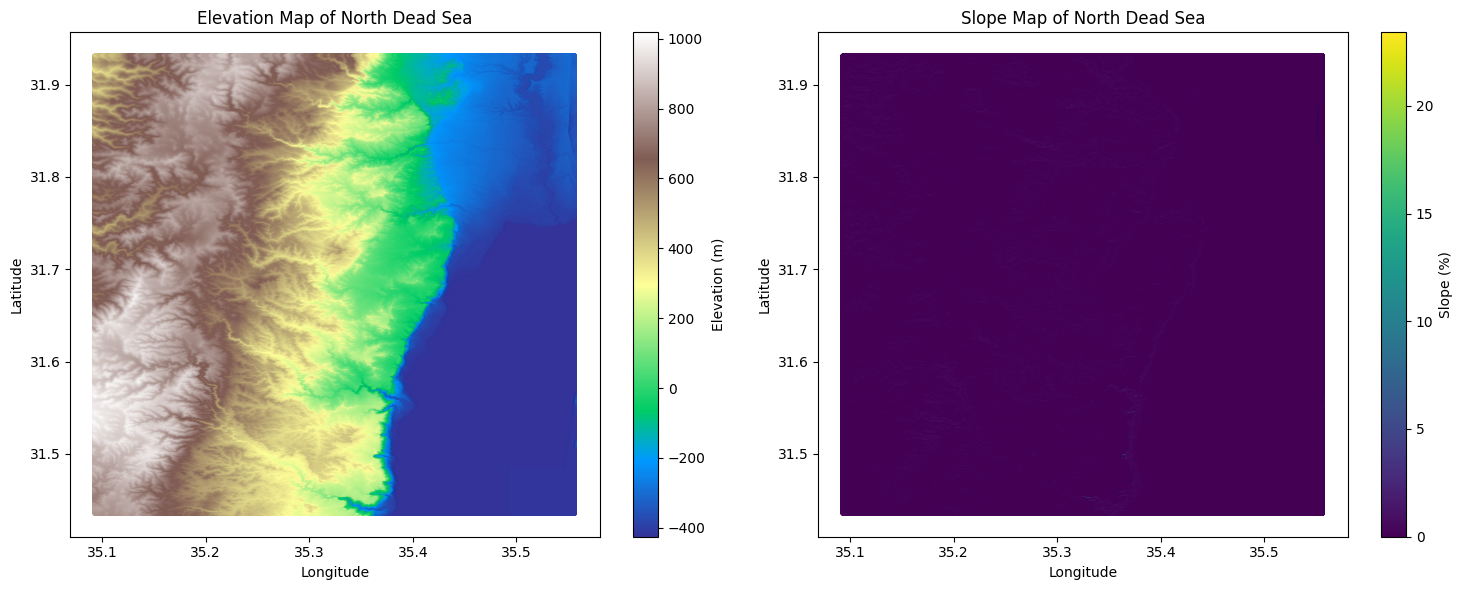

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define file paths
dem_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM.csv"
slope_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_SLOPE.csv"
output_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM_SLOPE_MERGED.csv"

# Load the merged dataset
merged_df = pd.read_csv(output_path)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for elevation
sc1 = axes[0].scatter(merged_df['Longitude'], merged_df['Latitude'], c=merged_df['elevation'], cmap='terrain', s=1)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('Elevation (m)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Elevation Map of North Dead Sea')

# Scatter plot for slope
sc2 = axes[1].scatter(merged_df['Longitude'], merged_df['Latitude'], c=merged_df['Slope'], cmap='viridis', s=1)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Slope (%)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Slope Map of North Dead Sea')

# Adjust layout
plt.tight_layout()
plt.show()

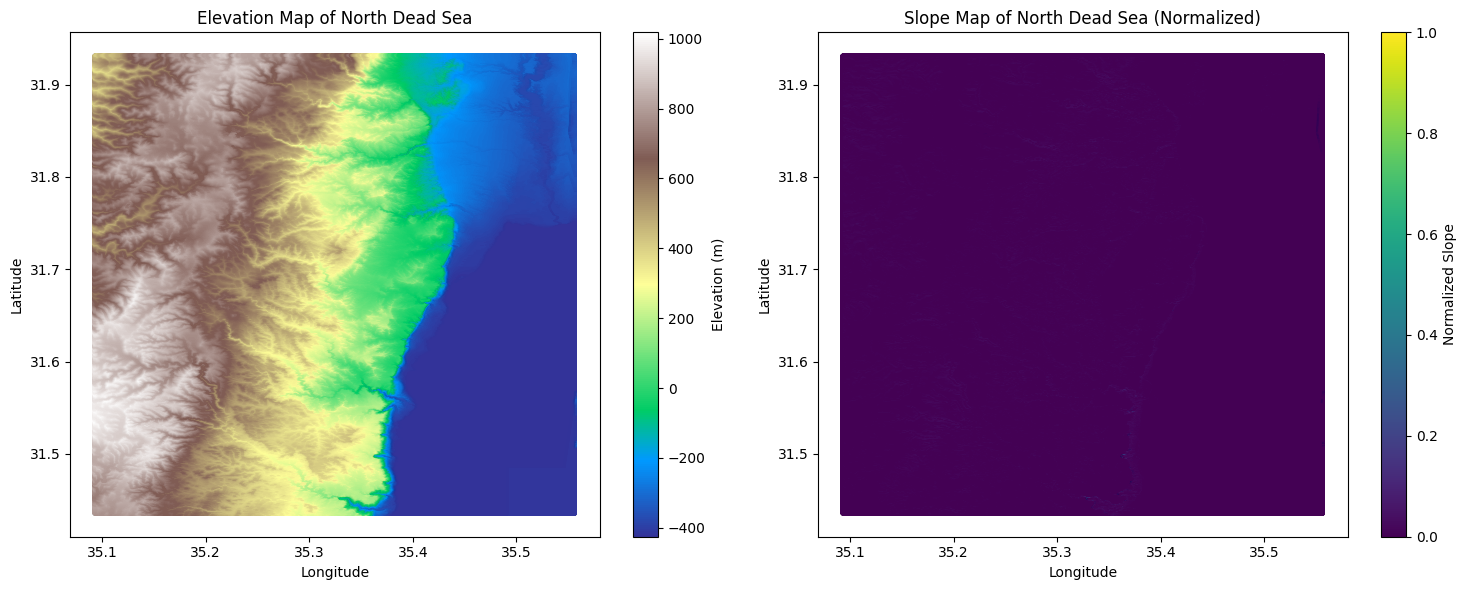

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define file paths
dem_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM.csv"
slope_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_SLOPE.csv"
output_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM_SLOPE_MERGED.csv"

# Load the merged dataset
merged_df = pd.read_csv(output_path)

# Normalize slope values for better visualization
slope_min = merged_df['Slope'].min()
slope_max = merged_df['Slope'].max()
if slope_max > slope_min:
    merged_df['Slope_Norm'] = (merged_df['Slope'] - slope_min) / (slope_max - slope_min)
else:
    merged_df['Slope_Norm'] = merged_df['Slope']  # Avoid division by zero

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for elevation
sc1 = axes[0].scatter(merged_df['Longitude'], merged_df['Latitude'], c=merged_df['elevation'], cmap='terrain', s=1)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('Elevation (m)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Elevation Map of North Dead Sea')

# Scatter plot for normalized slope
sc2 = axes[1].scatter(merged_df['Longitude'], merged_df['Latitude'], c=merged_df['Slope_Norm'], cmap='viridis', s=1)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Normalized Slope')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Slope Map of North Dead Sea (Normalized)')

# Adjust layout
plt.tight_layout()
plt.show()

Slope min: 0.0, Slope max: 23.409810193308267


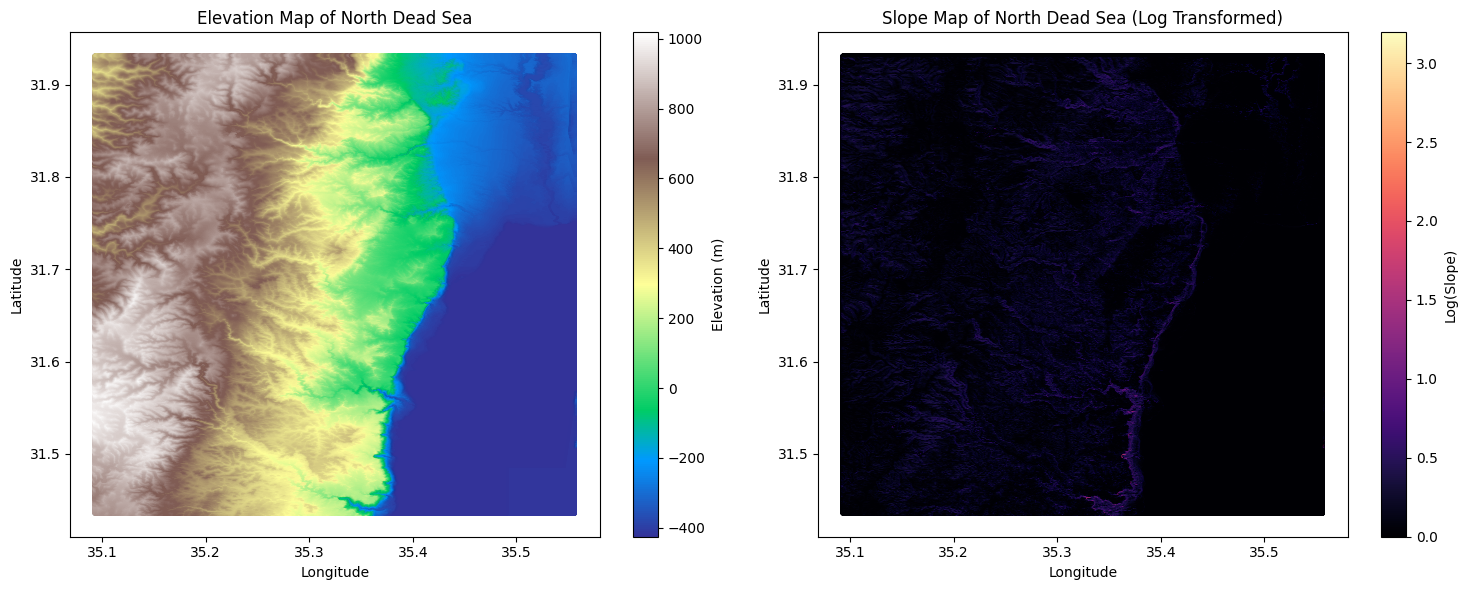

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define file paths
dem_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM.csv"
slope_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_SLOPE.csv"
output_path = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/DEM-SLOPE- ETC/North_Dead_Sea_DEM_SLOPE_MERGED.csv"

# Load the merged dataset
merged_df = pd.read_csv(output_path)

# Print slope min and max values
slope_min = merged_df['Slope'].min()
slope_max = merged_df['Slope'].max()
print(f"Slope min: {slope_min}, Slope max: {slope_max}")

# Apply logarithmic transformation to enhance visualization
merged_df['Slope_Log'] = np.log1p(merged_df['Slope'])  # log(1 + slope) to avoid log(0)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for elevation
sc1 = axes[0].scatter(merged_df['Longitude'], merged_df['Latitude'], c=merged_df['elevation'], cmap='terrain', s=1)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('Elevation (m)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Elevation Map of North Dead Sea')

# Scatter plot for logarithmic slope
sc2 = axes[1].scatter(merged_df['Longitude'], merged_df['Latitude'], c=merged_df['Slope_Log'], cmap='magma', s=1)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Log(Slope)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Slope Map of North Dead Sea (Log Transformed)')

# Adjust layout
plt.tight_layout()
plt.show()


In [30]:
pip install geopandas rasterstats rasterio


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 681.8 kB/s eta 0:00:00 kB/s eta 0:00:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 5.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 6.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
